#### Import

In [ ]:
import time

import random as python_random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from tensorflow.keras.utils import to_categorical

from mlxtend.plotting import plot_confusion_matrix


rseed = 42
np.random.seed(rseed)
python_random.seed(rseed)
tf.random.set_seed(rseed)

#### Load Data

In [3]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_val = pd.read_csv('..\data\X_val.csv')
X_test = pd.read_csv('..\data\X_test.csv')

y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_val_bin = pd.read_csv('..\data\y_val_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')

y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_val_multi = pd.read_csv('..\data\y_val_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

In [4]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

#### Training

In [5]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', metrics = ['accuracy']):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(num_classes, activation = 'softmax'))
    
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

In [6]:
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

In [7]:
epsilons

array([0.1   , 0.01  , 0.001 , 0.0001])

Train binary and multiclass models for Adam, SGD, and Adam.

In [9]:
#jupyter works a bit differently from a normal IDE 
#so we have to set random seed again in this cell
tf.random.set_seed(rseed)

count = 1
epochs = 30
batch_size = 10**3
start = time.time()

#5 learning rates equally spaced between 1/10,000 and 1/100
for eps in epsilons:
    
    #create the 3 optimizer with learning rate above
#     sgd_opt = tf.keras.optimizers.SGD(learning_rate = eps,
#                                       momentum = 0.9,
#                                       nesterov = False)

    # nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
    #                                   momentum = 0.9, 
    #                                   nesterov = True)
    
    
    adam_opt = tf.keras.optimizers.Adam(learning_rate = eps)

    #fit same model architecture for each optimizer
    for opt in ['adam']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #record model history fitting to binary training data with validation split
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = epochs, batch_size = batch_size,
                                              verbose = 0)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
        
        #delete temp model and history to free up memory
        del bin_model_temp
        del bin_history_temp
    
    
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = epochs, batch_size = batch_size,
                                                  verbose = 0)
    
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
        del categ_model_temp
        del categ_history_temp
        print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to adam optimizer with learning rate 0.1----------
----------Fitting categorical model to adam optimizer with learning rate 0.1----------

----------Fitting binary model to adam optimizer with learning rate 0.01----------
----------Fitting categorical model to adam optimizer with learning rate 0.01----------

----------Fitting binary model to adam optimizer with learning rate 0.001----------
----------Fitting categorical model to adam optimizer with learning rate 0.001----------

----------Fitting binary model to adam optimizer with learning rate 0.0001----------
----------Fitting categorical model to adam optimizer with learning rate 0.0001----------



In [10]:
print('Time taken to run all models:  {:2f} seconds'.format(end-start))

Time taken to run all models:  332.100170 seconds


### Plots and Assessing Performance

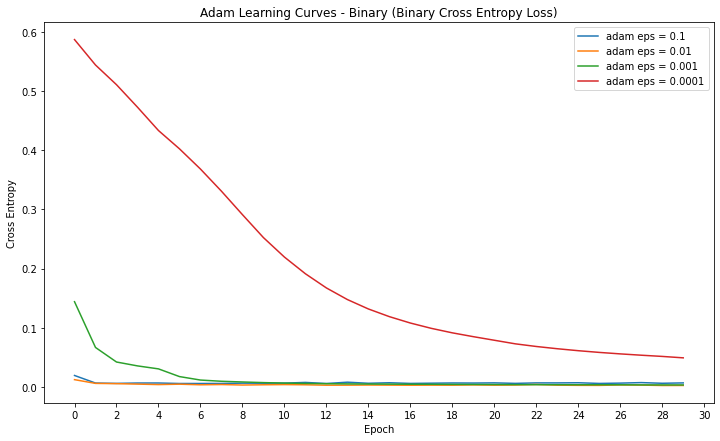

In [25]:
fig = plt.figure(figsize=(12,7))

plt.title('Adam Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

count=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1

# plt.plot(adam_bin_history_5.history['val_loss'],label='adam eps = 0.0001')

plt.legend()
plt.show()

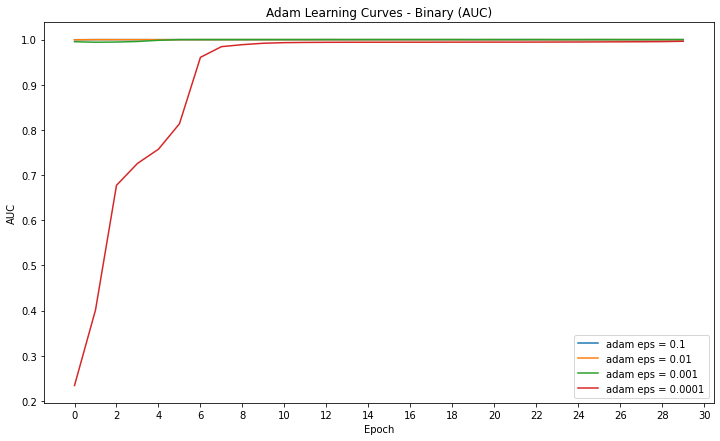

In [22]:
fig = plt.figure(figsize=(12,7))

plt.title('Adam Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')

count=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1# plt.plot(adam_bin_history_5.history['val_auc'],label='adam eps = 0.0001')

plt.legend()
plt.show()

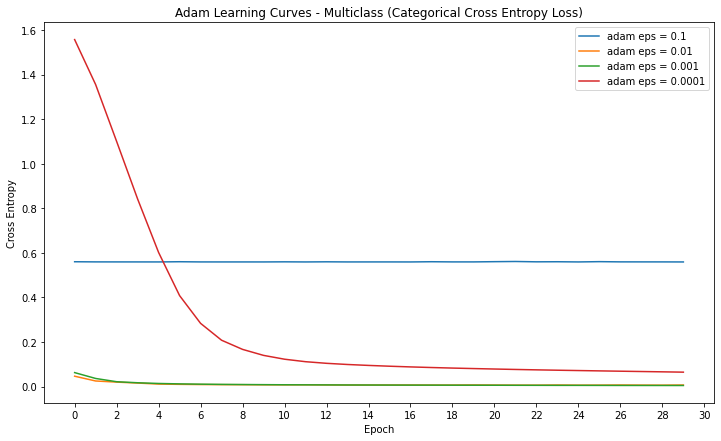

In [23]:
fig = plt.figure(figsize=(12,7))

plt.title('Adam Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

count=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1

plt.legend()
plt.show()

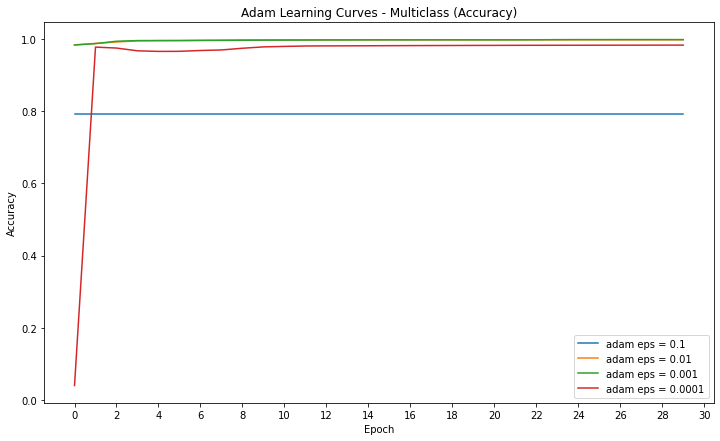

In [24]:
fig = plt.figure(figsize=(12,7))

plt.title('Adam Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

count=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1

plt.legend()
plt.show()

In [16]:
tf.random.set_seed(rseed)
adam_pred = adam_bin_model_1.predict(X_test)

In [17]:
adam_pred_bin = adam_pred
adam_pred_bin[adam_pred_bin>0.5]=1
adam_pred_bin[adam_pred_bin<0.5]=0

Text(0.5, 1.0, 'Confusion Matrix for Adam with learning rate 0.1')

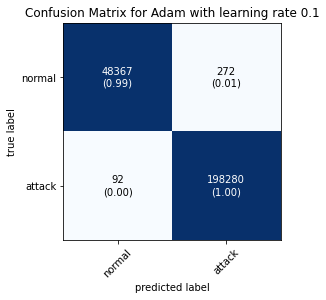

In [26]:
cmat_adam = confusion_matrix(y_test_bin,adam_pred)
cmat_adam

plot_confusion_matrix(
    conf_mat = cmat_adam,
    show_normed = True,
    class_names = ['normal','attack']
)

plt.title('Confusion Matrix for Adam with learning rate {}'.format(epsilons[0]))

In [27]:
tf.random.set_seed(rseed)

for i in range(len(epsilons)):
    
    model = locals()['adam_categ_model_{}'.format(i+1)]
    adam_categ_pred = model.predict(X_test)
    locals()['adam_categ_pred_{}'.format(i+1)] = adam_categ_pred

In [28]:
categs

Index(['dos', 'normal', 'probe', 'r2l', 'u2r'], dtype='object')

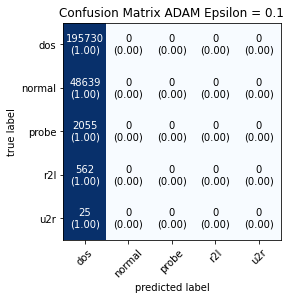

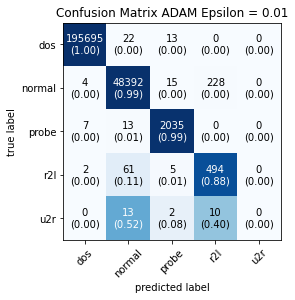

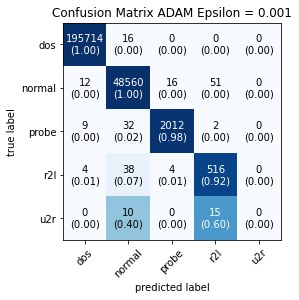

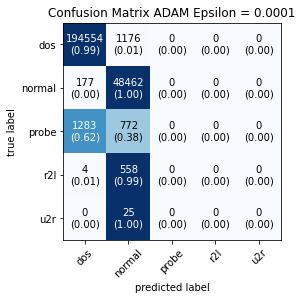

In [29]:
for i in range(len(epsilons)):
    adam_categ_pred = locals()['adam_categ_pred_{}'.format(i+1)]
    
    cmat_categ_adam = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(adam_categ_pred,axis=1))
    
    locals()['cmat_categ_adam_{}'.format(i)] = cmat_categ_adam
   
    
    
    plot_confusion_matrix(
        conf_mat = cmat_categ_adam,
        show_normed = True,
        class_names = categs
    )
    plt.title('Confusion Matrix {} Epsilon = {}'.format(opt.upper(),epsilons[i]))
    
del adam_categ_pred

# OLD

Train binary and multiclass models for Adam, SGD, and Adam.

In [5]:
count = 1

start = time.time()

#5 learning rates equally spaced between 1/10,000 and 1/100
for eps in np.linspace(1/10000,1/100,5):
    
    eps = round(eps,5)
    #create the 3 optimizer with learning rate above
#     sgd_opt = tf.keras.optimizers.SGD(learning_rate = eps,
#                                       momentum = 0.9,
#                                       nesterov = False)

#     nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
#                                       momentum = 0.9, 
#                                       nesterov = True)
    
    
    adam_opt = tf.keras.optimizers.Adam(learning_rate = eps)

    #fit same model architecture for each optimizer
    for opt in ['adam']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #record model history fitting to binary training data with validation split
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = 30, batch_size = 10000)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
        
        #delete temp model and history to free up memory
        del bin_model_temp
        del bin_history_temp
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = 30, batch_size = 10000)
    
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
        del categ_model_temp
        del categ_history_temp
        print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to adam optimizer with learning rate 0.0001----------
Epoch 1/30
5/5 [==============================] - 2s 201ms/step - loss: 0.5965 - auc: 0.5387 - val_loss: 0.5938 - val_auc: 0.5571
Epoch 2/30
5/5 [==============================] - 0s 61ms/step - loss: 0.5916 - auc: 0.5713 - val_loss: 0.5888 - val_auc: 0.5927
Epoch 3/30
5/5 [==============================] - 0s 64ms/step - loss: 0.5867 - auc: 0.6020 - val_loss: 0.5839 - val_auc: 0.6245
Epoch 4/30
5/5 [==============================] - 0s 68ms/step - loss: 0.5818 - auc: 0.6327 - val_loss: 0.5791 - val_auc: 0.6376
Epoch 5/30
5/5 [==============================] - 0s 68ms/step - loss: 0.5769 - auc: 0.6576 - val_loss: 0.5742 - val_auc: 0.6639
Epoch 6/30
5/5 [==============================] - 0s 65ms/step - loss: 0.5721 - auc: 0.6804 - val_loss: 0.5694 - val_auc: 0.6858
Epoch 7/30
5/5 [==============================] - 0s 65ms/step - loss: 0.5672 - auc: 0.7005 - val_loss: 0.5647 - val_auc: 0.7075
Epoch 8/30


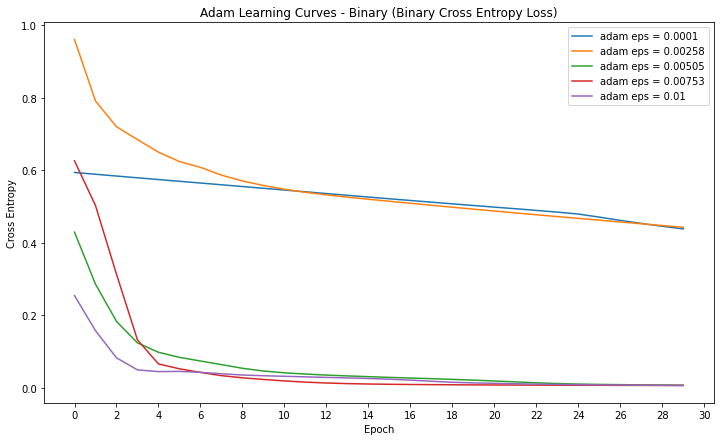

In [24]:
fig = plt.figure(figsize=(12,7))

plt.title('Adam Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(adam_bin_history_1.history['val_loss'],label='adam eps = 0.0001')
plt.plot(adam_bin_history_2.history['val_loss'],label='adam eps = 0.00258')
plt.plot(adam_bin_history_3.history['val_loss'],label='adam eps = 0.00505')
plt.plot(adam_bin_history_4.history['val_loss'],label='adam eps = 0.00753')
plt.plot(adam_bin_history_5.history['val_loss'],label='adam eps = 0.01')

plt.legend()
plt.show()

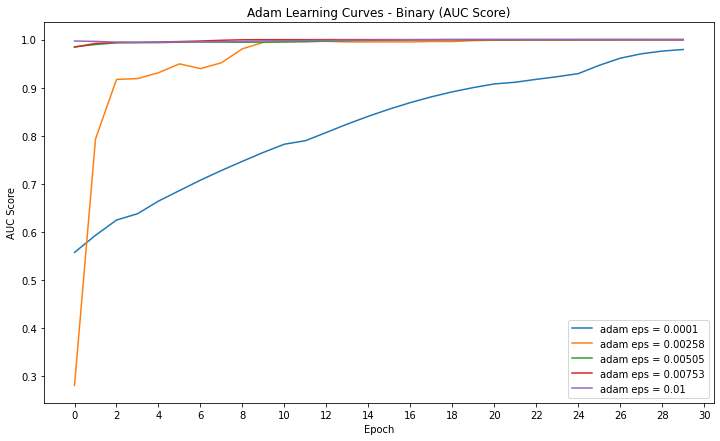

In [23]:
fig = plt.figure(figsize=(12,7))

plt.title('Adam Learning Curves - Binary (AUC Score)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('AUC Score')

plt.plot(adam_bin_history_1.history['val_auc'],label='adam eps = 0.0001')
plt.plot(adam_bin_history_2.history['val_auc'],label='adam eps = 0.00258')
plt.plot(adam_bin_history_3.history['val_auc'],label='adam eps = 0.00505')
plt.plot(adam_bin_history_4.history['val_auc'],label='adam eps = 0.00753')
plt.plot(adam_bin_history_5.history['val_auc'],label='adam eps = 0.01')

plt.legend()
plt.show()

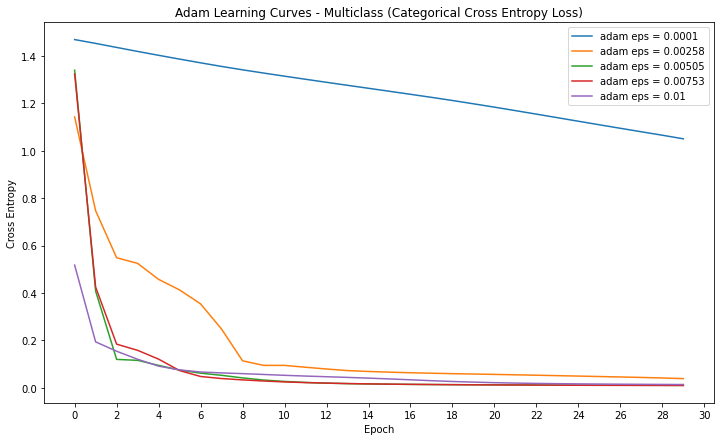

In [21]:
fig = plt.figure(figsize=(12,7))

plt.title('Adam Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(adam_categ_history_1.history['val_loss'],label='adam eps = 0.0001')
plt.plot(adam_categ_history_2.history['val_loss'],label='adam eps = 0.00258')
plt.plot(adam_categ_history_3.history['val_loss'],label='adam eps = 0.00505')
plt.plot(adam_categ_history_4.history['val_loss'],label='adam eps = 0.00753')
plt.plot(adam_categ_history_5.history['val_loss'],label='adam eps = 0.01')

plt.legend()
plt.show()

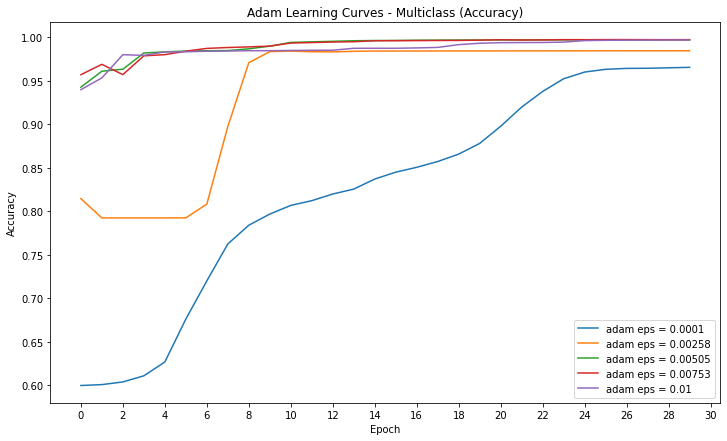

In [20]:
fig = plt.figure(figsize=(12,7))

plt.title('Adam Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

plt.plot(adam_categ_history_1.history['val_accuracy'],label='adam eps = 0.0001')
plt.plot(adam_categ_history_2.history['val_accuracy'],label='adam eps = 0.00258')
plt.plot(adam_categ_history_3.history['val_accuracy'],label='adam eps = 0.00505')
plt.plot(adam_categ_history_4.history['val_accuracy'],label='adam eps = 0.00753')
plt.plot(adam_categ_history_5.history['val_accuracy'],label='adam eps = 0.01')

plt.legend()
plt.show()

In [11]:
ad_pred = adam_bin_model_3.predict(X_test)

In [12]:
ad_pred_bin = ad_pred
ad_pred_bin[ad_pred_bin>0.5]=1
ad_pred_bin[ad_pred_bin<0.5]=0

In [13]:
from mlxtend.plotting import plot_confusion_matrix

In [14]:
import matplotlib

In [15]:
from sklearn.metrics import confusion_matrix

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

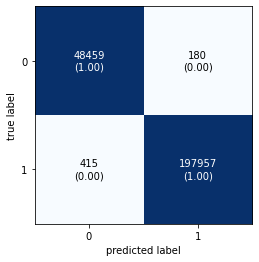

In [16]:
cmat_ad = confusion_matrix(y_test_bin,ad_pred)
cmat_ad
plot_confusion_matrix(
    conf_mat = cmat_ad,
    show_normed = True
)

In [17]:
ad_categ_pred = adam_categ_model_4.predict(X_test)

In [18]:
ad_categ_pred

array([[9.9999797e-01, 3.9154866e-13, 2.0190496e-06, 8.9587799e-12,
        4.8356102e-12],
       [9.9995685e-01, 1.5465121e-10, 4.3136995e-05, 1.8910390e-10,
        1.2155272e-11],
       [2.4700064e-06, 9.9990773e-01, 1.8198300e-05, 7.1587587e-05,
        6.7536190e-09],
       ...,
       [9.9995685e-01, 1.5465121e-10, 4.3136995e-05, 1.8910390e-10,
        1.2155249e-11],
       [1.2248753e-06, 9.9775416e-01, 7.4573304e-04, 1.4962438e-03,
        2.7209358e-06],
       [9.9999940e-01, 7.0482662e-14, 6.0213108e-07, 1.7912938e-12,
        1.2011162e-12]], dtype=float32)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

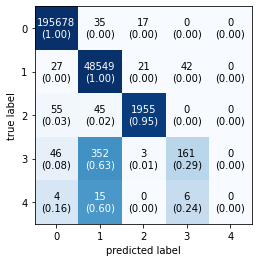

In [19]:
cmat_ad = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(ad_categ_pred,axis=1))

plot_confusion_matrix(
    conf_mat = cmat_ad,
    show_normed = True
)